<a href="https://colab.research.google.com/github/DomBBB/MLHSG/blob/main/EuroSAT_Pix2Pix_visualizationtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EuroSAT Challenge: Model

This notebook trains the model for the EuroSAT challenge. It uses a Google Colab (A100 GPU) runtime with extended RAM and stores all generated data on Google Drive. It populates the previously created models folder and stores the final predictions:
* models
  * Pix2Pix_Model_*
    * checkpoints
    * results.zip
    * train_rft.zip
    * test_rft.zip
  * resnet_*.pt
* model_*.csv


## Mount the drive

We mount the drive to store data permanently on Google Drive.

In [1]:
from google.colab import drive
import os

drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/MLHSG/")

Mounted at /content/drive


## Load data into current runtime

We load our training multispectral data, testing multispectral data, Major TOM data, and (own) AB data into our current runtime. This drastically improves all operations on the data.

In [2]:
if not os.path.exists(os.path.expanduser("~/trainingdataMS")):
    os.makedirs(os.path.expanduser("~/trainingdataMS"))
    !cp dataMS/EuroSAT_MS.zip ~/trainingdataMS/EuroSAT_MS.zip
    !unzip -q ~/trainingdataMS/EuroSAT_MS.zip -d ~/trainingdataMS
print("Data loaded locally.")

Data loaded locally.


In [3]:
if not os.path.exists(os.path.expanduser("~/aiml-coding-challenge-fs24.zip")):
    !cp test/aiml-coding-challenge-fs24.zip ~/aiml-coding-challenge-fs24.zip
    !unzip -q ~/aiml-coding-challenge-fs24.zip -d ~/
    !mv ~/train.csv ~/trainingdataMS/EuroSAT_MS/train.csv
    !rm ~/sample_submission.csv
    !rm ~/test.csv
print("Data loaded locally.")

Data loaded locally.


In [ ]:
if not os.path.exists(os.path.expanduser("~/dataMajTOM")):
    os.makedirs(os.path.expanduser("~/dataMajTOM"))
    os.makedirs(os.path.expanduser("~/dataMajTOM/train"))
    os.makedirs(os.path.expanduser("~/dataMajTOM/train_full"))
    os.makedirs(os.path.expanduser("~/dataMajTOM/test"))
    for zip_file in sorted(os.listdir("dataMajTOM_MS")):
      print(f"Extracting {zip_file}")
      if zip_file.startswith("MajTOM_train"):
        !mkdir -p ~/temp_extract
        !cp dataMajTOM_MS/{zip_file} ~/temp_extract/{zip_file}
        !unzip -q ~/temp_extract/{zip_file} -d ~/temp_extract
        # need to handle> /usr/bin/mv: Argument list too long
        !find ~/temp_extract/root/MajTOM/train/ -type f -exec mv {} ~/dataMajTOM/train_full/ \;
        !rm -r ~/temp_extract
      elif zip_file.startswith("MajTOM_test"):
        !mkdir -p ~/temp_extract
        !cp dataMajTOM_MS/{zip_file} ~/temp_extract/{zip_file}
        !unzip -q ~/temp_extract/{zip_file} -d ~/temp_extract
        !mv ~/temp_extract/root/MajTOM/test/* ~/dataMajTOM/test
        !rm -r ~/temp_extract
      else:
        raise Error

print("Data loaded locally.")

Extracting MajTOM_test_0.zip
Extracting MajTOM_test_1.zip
Extracting MajTOM_test_2.zip
Extracting MajTOM_test_3.zip
Extracting MajTOM_test_4.zip
Extracting MajTOM_test_5.zip
Extracting MajTOM_test_6.zip
Extracting MajTOM_test_7.zip
Extracting MajTOM_train_0.zip
Extracting MajTOM_train_1.zip
Extracting MajTOM_train_2.zip
Extracting MajTOM_train_3.zip
Extracting MajTOM_train_4.zip
Extracting MajTOM_train_5.zip


In [ ]:
if not os.path.exists(os.path.expanduser("~/dataAB")):
    os.makedirs(os.path.expanduser("~/dataAB"))
    os.makedirs(os.path.expanduser("~/dataAB/train_transformed/test"))
    os.makedirs(os.path.expanduser("~/dataAB/test_transformed/test"))

    !mkdir -p ~/temp_extract
    !cp dataAB_MS/DataAB_train.zip ~/temp_extract/DataAB_train.zip
    !unzip -q ~/temp_extract/DataAB_train.zip -d ~/temp_extract
    !mv ~/temp_extract/root/dataAB/train_transformed/* ~/dataAB/train_transformed/test
    !rm -r ~/temp_extract

    !mkdir -p ~/temp_extract
    !cp dataAB_MS/DataAB_test.zip ~/temp_extract/DataAB_test.zip
    !unzip -q ~/temp_extract/DataAB_test.zip -d ~/temp_extract
    !mv ~/temp_extract/root/dataAB/test_transformed/* ~/dataAB/test_transformed/test
    !rm -r ~/temp_extract

print("Data loaded locally.")

## Pix2Pix

We use Pix2Pix to transform our level 1C training data to level 2A, which is the same level as the testing data.

Pix2Pix is a type of conditional Generative Adversarial Network (cGAN) designed to transform an input image into an output image. It learns this mapping through a paired training approach, where a generator model creates images that are evaluated by a discriminator model.

The Generator in Pix2Pix utilizes a U-Net architecture, a form of convolution-BatchNorm-ReLu, effective for tasks requiring precise alignment between input and output images, such as semantic segmentation or style transfer. It features a symmetric design with a contracting path that downsamples the image, capturing complex features at reduced dimensions, and an expansive path that upsamples feature maps. Skip connections between the paths help to circumvent the bottleneck for information, inherent to such a network. The Discriminator employs a PatchGAN design (also for of onvolution-BatchNorm-ReLu), which, instead of assessing whole images for authenticity, evaluates small, localized patches independently. This allows it to focus on local structures in the image patches and model high-frequency structure while relying on an L1 term to force low-frequency correctness. Ultimately, that leads to less blurry results.


### Setup

We can download a pytorch implementation of Pix2Pix directly from Github. This implementation is suited for 256x256 RGB images, which is why we introduce a few changes in the library to use the model for our 64x64 patches with 4 channels.

In [49]:
!git clone -q https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix ~/pytorch-CycleGAN-and-pix2pix

# Here we define a new Unet generator that with less layers, suited for 64x64 patches
network_definitions = os.path.expanduser("~/pytorch-CycleGAN-and-pix2pix/models/networks.py")
with open(network_definitions, 'r') as file:
  lines = file.readlines()

new_block = "    elif netG == 'unet_64':\n        net = UnetGenerator(input_nc, output_nc, 6, ngf, norm_layer=norm_layer, use_dropout=use_dropout)\n"

for i, line in enumerate(lines):
  if "elif netG == 'unet_128':" in line:
    lines.insert(i, new_block)
    break

with open(network_definitions, 'w') as file:
  file.writelines(lines)

# Here we rewrite the dataloader such that it can handle .npy images with 4 channels (instead of 3)
dataset_definitions = os.path.expanduser("~/pytorch-CycleGAN-and-pix2pix/data/aligned_dataset.py")
with open(dataset_definitions, 'r') as file:
  lines = file.readlines()

for i, line in enumerate(lines):
  if i == 0:
    lines[i] = "import numpy as np \n" + "import os \n"
  elif i == 40:
    lines[i] = "        AB = np.interp(np.load(AB_path), (0, 2750), (0, 255)).astype(np.uint8) \n"
  elif i == 42:
    lines[i] = "        h, w, channel_dummy = AB.shape \n"
  elif i == 44:
    lines[i] = "        A = AB[:, :64, :] \n"
  elif i == 45:
    lines[i] = "        B = AB[:, 64:128, :] \n"
  elif i == 48:
    lines[i] = "        transform_params = get_params(self.opt, A.shape[0:2]) \n"

with open(dataset_definitions, 'w') as file:
  file.writelines(lines)

# Here we rewrite the transformations that are applied onto the .npy images
basedataset_definitions = os.path.expanduser("~/pytorch-CycleGAN-and-pix2pix/data/base_dataset.py")
with open(basedataset_definitions, 'r') as file:
  lines = file.readlines()

for i, line in enumerate(lines):
  if i == 110:
    lines[i] = "            transform_list += [transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))] \n"
  if i == 155:
    lines[i] = "        return np.fliplr(img).copy() \n"

lines = lines[:96] + lines[98:]

with open(basedataset_definitions, 'w') as file:
  file.writelines(lines)

# Here we allow the dataloader to also load .npy images
imageloader_definitions = os.path.expanduser("~/pytorch-CycleGAN-and-pix2pix/data/image_folder.py")
with open(imageloader_definitions, 'r') as file:
  lines = file.readlines()

for i, line in enumerate(lines):
  if i == 14:
    lines[i] = "    '.tif', '.TIF', '.tiff', '.TIFF', '.npy' \n"

with open(imageloader_definitions, 'w') as file:
  file.writelines(lines)

# Here we define the output of the model such that we can store the output images again as .npy arrays
visualizer_definitions = os.path.expanduser("~/pytorch-CycleGAN-and-pix2pix/util/visualizer.py")
with open(visualizer_definitions, 'r') as file:
  lines = file.readlines()

for i, line in enumerate(lines):
  if i == 40:
    lines[i] = "        im = util.tensor2im(im_data, np.uint8) \n"
  if i == 41:
    lines[i] = "        image_name = '%s_%s.npy' % (name, label) \n"
  if i == 43:
    lines[i] = "        np.save(save_path, im) \n"

with open(visualizer_definitions, 'w') as file:
  file.writelines(lines)

In [ ]:
!pip install -q -r ~/pytorch-CycleGAN-and-pix2pix/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 69.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvi

### Train

We define the name of the Pix2Pix model such that we can store its checkpoints and later also directly work with the trained model or its output.

In [52]:
model_name_suffix = "7"

model_name_suffix = "Pix2Pix_Model_" + model_name_suffix
if not os.path.exists(os.path.expanduser(f"./models/{model_name_suffix}")):
  os.makedirs(os.path.expanduser(f"./models/{model_name_suffix}"))

We create a random subset of our data that contains only around 10% of all our training data. Because many of our images are similar (as 256 images come from the same Major TOM grid cell), we can speed up computation like that. Additionally, in our tests we had a better performance by subsetting (even 8'000 images yielded good results, when training enough epochs).

Considering all of this, we decided to take 80'000 images.

In [ ]:
!ls ~/dataMajTOM/train_full | shuf -n 80000 | xargs -I {} cp ~/dataMajTOM/train_full/{} ~/dataMajTOM/train

We need to set various options, such as the model to use, the input and output channels, the generator and disciminator, the direction and how many epochs. It is expecially noteworthy, that we use a smaller Unet generator and a smaller PatchGAN discriminator (reduced layers). An explanation of all options is available in the Pix2Pix Github.

With the same reasoning as above we decided to only use 2 epochs.

In [ ]:
!python ~/pytorch-CycleGAN-and-pix2pix/train.py \
  --netG unet_64 --netD n_layers --n_layers_D 2 \
  --input_nc 4 --output_nc 4 \
  --dataroot ~/dataMajTOM --name pix2pix_MajTOM \
  --model pix2pix --direction AtoB \
  --display_id -1 \
  --preprocess none \
  --n_epochs 1 --n_epochs_decay 1 --save_epoch_freq 1 \
  --checkpoints_dir models/{model_name_suffix}/checkpoints

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: models/Pix2Pix_Model_4/checkpoints	[default: ./checkpoints]
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /root/dataMajTOM              	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: lat

We get a loss log from training our model. Let's visualize it to make the printed output from above comprehensible.

In [62]:
import re
import matplotlib.pyplot as plt

nb_data = 80000
line_interval = 10

log_path = os.path.expanduser(f"./models/{model_name_suffix}/checkpoints/pix2pix_MajTOM/loss_log.txt")
with open(log_path, 'r') as f:
    lines = f.readlines()

lines_for_plot = []
for i in range(1, len(lines)):
    if (i-1) % line_interval == 0:
        lines_for_plot.append(lines[i])
lines_for_plot.append(lines[-1])

dicts = dict()
dicts["epoch"] = []
parts = (lines_for_plot[0]).split(') ')[1].split(' ')
for i in range(0, len(parts) // 2):
    dicts[parts[2*i][:-1]] = []

pattern = "epoch: ([0-9]+), iters: ([0-9]+)"
for l in lines_for_plot:
    search = re.search(pattern, l)
    epoch = int(search.group(1))
    epoch_floatpart = int(search.group(2)) / nb_data
    dicts["epoch"].append(epoch + epoch_floatpart)
    parts = l.split(') ')[1].split(' ')
    for i in range(0, len(parts) // 2):
        dicts[parts[2*i][:-1]].append(float(parts[2*i+1]))

G_GAN is the generator GAN loss and measures how well the generator is able to fool the discriminator. A lower G_GAN loss indicates that the generator is improving in its ability to create realistic images.

G_L1 is the generator L1 loss between the generated images and the real images. It encourages the generator to produce output closer to the real images.

D_real and D_fake are the discriminator real and fake loss, which measure how well the discriminator is able to recognize real images as real and generated images as fake. Lower losses indicate that the discriminator is improving its ability to discriminate generated images.

Ideally, all losses should be reasonably low. However, as often in GANs, they do not converge (see [link](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/qa.md)). Only the G_L1 should go down over time, which it slightly does in our case (see [link](https://github.com/phillipi/pix2pix/issues/21)).

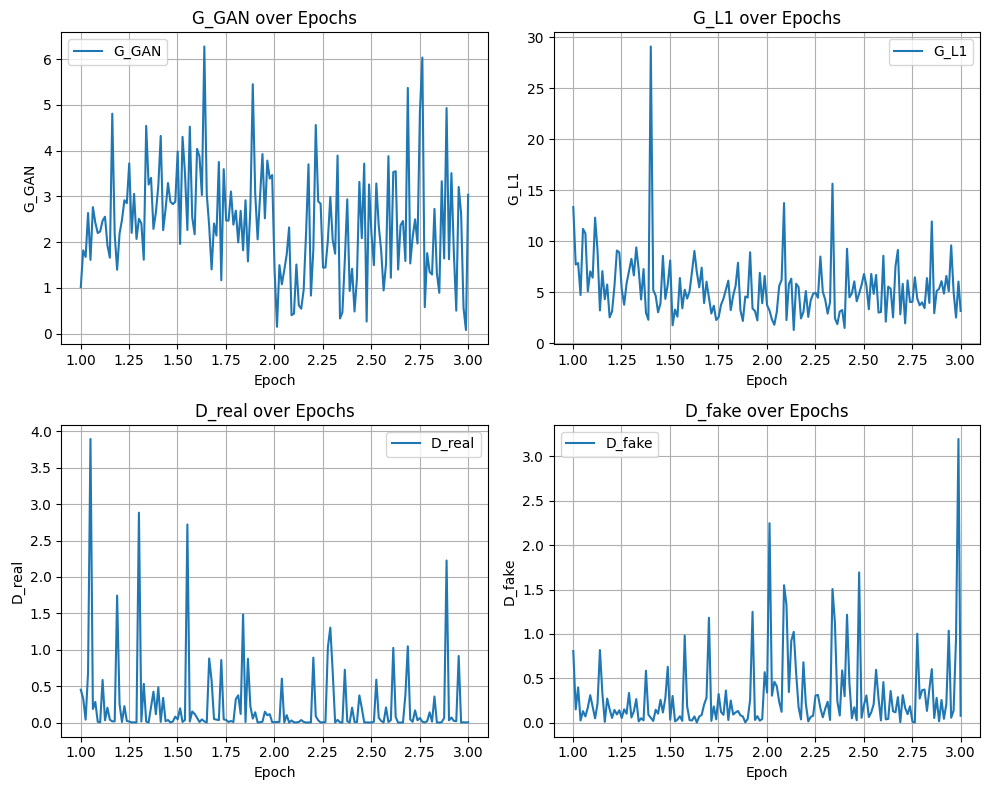

In [63]:
plt.figure(figsize=(10, 8))
keys = list(dicts.keys())[1:]

for i, key in enumerate(keys, 1):
    ax = plt.subplot(2, 2, i)
    ax.plot(dicts["epoch"], dicts[key], label=key)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(key)
    ax.set_title(f"{key} over Epochs")
    ax.legend(loc="best")
    ax.grid(True)

plt.tight_layout()
plt.show()

### Test

Similar to training, we also need to set options here. It is important that we use exactly the same model specification as in training.

We only look at 50 exemplary images and store the results in Google Drive.

In [ ]:
!python ~/pytorch-CycleGAN-and-pix2pix/test.py \
  --netG unet_64 --netD n_layers --n_layers_D 2 \
  --input_nc 4 --output_nc 4 \
  --dataroot ~/dataMajTOM --name pix2pix_MajTOM \
  --model pix2pix --direction AtoB \
  --preprocess none \
  --num_test 50 \
  --checkpoints_dir models/{model_name_suffix}/checkpoints \
  --results_dir ~/results/

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: models/Pix2Pix_Model_4/checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /root/dataMajTOM              	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 4                             	[default: 3]
                  isTrain: False                         	[default: None]
              

In [ ]:
!zip -r ~/results.zip ~/results
!mv ~/results.zip ./models/{model_name_suffix}/

  adding: root/results/ (stored 0%)
  adding: root/results/pix2pix_MajTOM/ (stored 0%)
  adding: root/results/pix2pix_MajTOM/test_latest/ (stored 0%)
  adding: root/results/pix2pix_MajTOM/test_latest/index.html (deflated 97%)
  adding: root/results/pix2pix_MajTOM/test_latest/images/ (stored 0%)
  adding: root/results/pix2pix_MajTOM/test_latest/images/image_100167_fake_B.npy (deflated 10%)
  adding: root/results/pix2pix_MajTOM/test_latest/images/image_100142_fake_B.npy (deflated 17%)
  adding: root/results/pix2pix_MajTOM/test_latest/images/image_100006_real_B.npy (deflated 59%)
  adding: root/results/pix2pix_MajTOM/test_latest/images/image_100383_real_B.npy (deflated 7%)
  adding: root/results/pix2pix_MajTOM/test_latest/images/image_100268_real_A.npy (deflated 12%)
  adding: root/results/pix2pix_MajTOM/test_latest/images/image_100285_real_B.npy (deflated 17%)
  adding: root/results/pix2pix_MajTOM/test_latest/images/image_100161_fake_B.npy (deflated 12%)
  adding: root/results/pix2pix_Ma

We visualize an exemplary test image. We decide to look at the RGB image, but also did a check for the fourth channel.

This step is very important in our Pix2Pix model (and generally in many GANs) because the losses do (with some exceptions) not converge. So visual inspection is an important tool to inspect the model's working.

We can see the conversion that we need from the real A (L1C) to the real B (L2A). The fake B is the (L2A) image that the model created, only from looking at the real A. We can see, that it seems to work.

In [ ]:
import numpy as np

img_num = 50
example_image = os.path.join("~/results/pix2pix_MajTOM/test_latest/images/", sorted(os.listdir(os.path.expanduser("~/results/pix2pix_MajTOM/test_latest/images/")))[img_num])

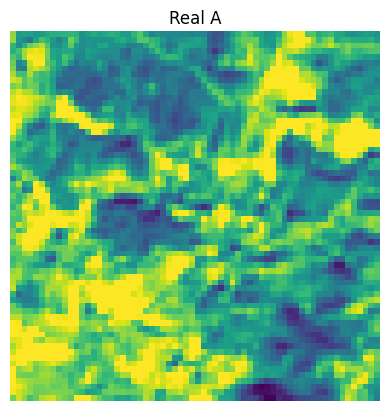

In [ ]:
img_path = example_image[:-10] + "real_A.npy"
img = np.load(os.path.expanduser(img_path))
image = img[:, :, [2, 1, 0]]
# image = img[:, :, [3]]

plt.imshow(image)
plt.title("Real A")
plt.axis('off')
plt.show()

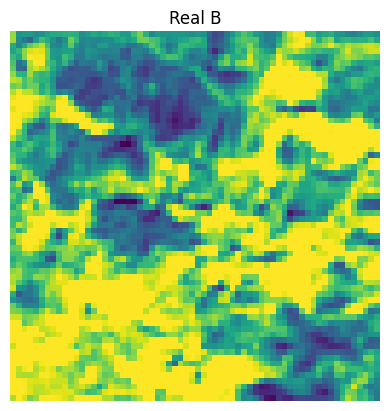

In [ ]:
img_path = example_image[:-10] + "real_B.npy"
img = np.load(os.path.expanduser(img_path))
image = img[:, :, [2, 1, 0]]
# image = img[:, :, [3]]

plt.imshow(image)
plt.title("Real B")
plt.axis('off')
plt.show()

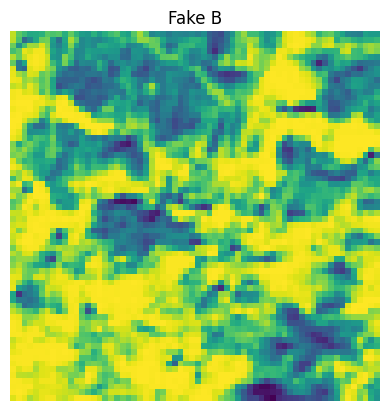

In [ ]:
img_path = example_image[:-10] + "fake_B.npy"
img = np.load(os.path.expanduser(img_path))
image = img[:, :, [2, 1, 0]]
# image = img[:, :, [3]]

plt.imshow(image)
plt.title("Fake B")
plt.axis('off')
plt.show()

### Transform our training images

We now convert all of our 27'000 L1C training images to their L2A equivalent. This is similar as the testing step and stores all images (the 3 shown above for each of the 27'000 originals) in the zip file train_rft.zip.

In [ ]:
!python ~/pytorch-CycleGAN-and-pix2pix/test.py \
  --netG unet_64 --netD n_layers --n_layers_D 2 \
  --input_nc 4 --output_nc 4 \
  --dataroot ~/dataAB/train_transformed --name pix2pix_MajTOM \
  --model pix2pix --direction AtoB \
  --preprocess none \
  --num_test {len(os.listdir(os.path.expanduser("~/dataAB/train_transformed/test")))} \
  --checkpoints_dir models/{model_name_suffix}/checkpoints \
  --results_dir ~/train_rft/

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
processing (2000)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_28.npy']
processing (2005)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_2803.npy']
processing (2010)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_2808.npy']
processing (2015)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_2812.npy']
processing (2020)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_2817.npy']
processing (2025)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_2821.npy']
processing (2030)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_2826.npy']
processing (2035)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_2830.npy']
processing (2040)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_2835.npy']
processing (2045)-th image... ['/root/dataAB/train_transformed/test/AnnualCrop_284.npy']
processing (2050)-th image... ['/roo

In [ ]:
!zip -r ~/train_rft.zip ~/train_rft
!mv ~/train_rft.zip ./models/{model_name_suffix}/

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: root/train_rft/pix2pix_MajTOM/test_latest/images/AnnualCrop_2011_real_A.npy (deflated 50%)
  adding: root/train_rft/pix2pix_MajTOM/test_latest/images/Forest_2281_real_B.npy (deflated 99%)
  adding: root/train_rft/pix2pix_MajTOM/test_latest/images/HerbaceousVegetation_2561_real_A.npy (deflated 14%)
  adding: root/train_rft/pix2pix_MajTOM/test_latest/images/AnnualCrop_2935_real_A.npy (deflated 21%)
  adding: root/train_rft/pix2pix_MajTOM/test_latest/images/HerbaceousVegetation_6_real_B.npy (deflated 99%)
  adding: root/train_rft/pix2pix_MajTOM/test_latest/images/HerbaceousVegetation_2262_real_A.npy (deflated 22%)
  adding: root/train_rft/pix2pix_MajTOM/test_latest/images/HerbaceousVegetation_460_fake_B.npy (deflated 26%)
  adding: root/train_rft/pix2pix_MajTOM/test_latest/images/AnnualCrop_337_fake_B.npy (deflated 15%)
  adding: root/train_rft/pix2pix_MajTOM/test_latest/images/SeaLake_1861_real_B.npy (deflated 9

We visualize an example again to remember ourselves of the challenge that Pix2Pix is trying to solve. We see that there exists no real B, but the model still manages to create the fake B from the real A. The fake B looks similar to the real A and exactly with the color change that we would expect.

In [ ]:
img_num = 599
example_image = os.path.join("~/train_rft/pix2pix_MajTOM/test_latest/images/", sorted(os.listdir(os.path.expanduser("~/train_rft/pix2pix_MajTOM/test_latest/images/")))[img_num])

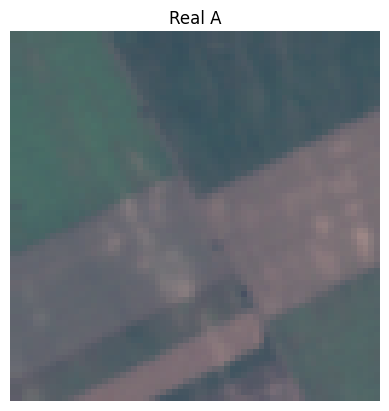

In [ ]:
img_path = example_image[:-10] + "real_A.npy"
img = np.load(os.path.expanduser(img_path))
image = img[:, :, [2, 1, 0]]
# image = img[:, :, [3]]

plt.imshow(image)
plt.title("Real A")
plt.axis('off')
plt.show()

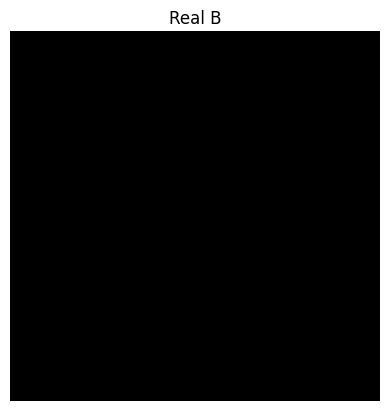

In [ ]:
img_path = example_image[:-10] + "real_B.npy"
img = np.load(os.path.expanduser(img_path))
image = img[:, :, [2, 1, 0]]
# image = img[:, :, [3]]

plt.imshow(image)
plt.title("Real B")
plt.axis('off')
plt.show()

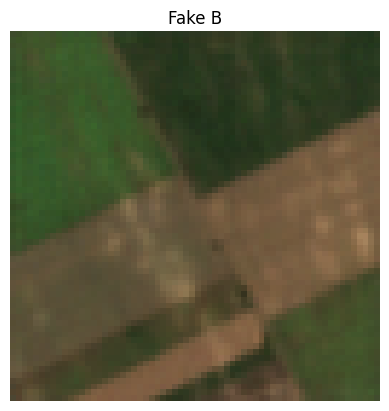

In [ ]:
img_path = example_image[:-10] + "fake_B.npy"
img = np.load(os.path.expanduser(img_path))
image = img[:, :, [2, 1, 0]]
# image = img[:, :, [3]]

plt.imshow(image)
plt.title("Fake B")
plt.axis('off')
plt.show()

### Transform our testing images

We also apply the model to the testing image. Because we only have a small amount of images it does not take long, which is why this was the easiest way to process and store the testing images in exactly the same way as the training images generated from Pix2Pix. This is similar as the two previous testing steps and stores all images (the 3 shown above for each of the ~4k originals) in the zip file test_rft.zip.

In [ ]:
!python ~/pytorch-CycleGAN-and-pix2pix/test.py \
  --netG unet_64 --netD n_layers --n_layers_D 2 \
  --input_nc 4 --output_nc 4 \
  --dataroot ~/dataAB/test_transformed --name pix2pix_MajTOM \
  --model pix2pix --direction AtoB \
  --preprocess none \
  --num_test {len(os.listdir(os.path.expanduser("~/dataAB/test_transformed/test")))} \
  --checkpoints_dir models/{model_name_suffix}/checkpoints \
  --results_dir ~/test_rft/

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: models/Pix2Pix_Model_4/checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /root/dataAB/test_transformed 	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 4                             	[default: 3]
                  isTrain: False                         	[default: None]
              

In [ ]:
!zip -r ~/test_rft.zip ~/test_rft
!mv ~/test_rft.zip ./models/{model_name_suffix}/

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_162_fake_B.npy (deflated 78%)
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_3379_fake_B.npy (deflated 78%)
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_788_fake_B.npy (deflated 78%)
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_2359_real_B.npy (deflated 32%)
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_2962_real_B.npy (deflated 19%)
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_869_real_A.npy (deflated 99%)
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_2851_fake_B.npy (deflated 78%)
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_629_real_B.npy (deflated 47%)
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_3111_real_B.npy (deflated 28%)
  adding: root/test_rft/pix2pix_MajTOM/test_latest/images/test_4175_fake_B.npy (deflated 78

We visualize an example again to remember ourselves of the challenge that we are trying to solve with Pix2Pix. For the testing images there exist no real A images. Thus, we used Pix2Pix to convert our training images to the same level as our testing images.

In [ ]:
img_num = 599
example_image = os.path.join("~/test_rft/pix2pix_MajTOM/test_latest/images/", sorted(os.listdir(os.path.expanduser("~/test_rft/pix2pix_MajTOM/test_latest/images/")))[img_num])

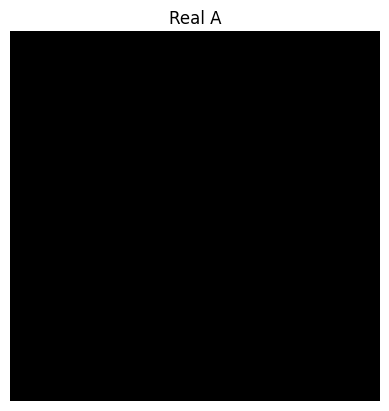

In [ ]:
img_path = example_image[:-10] + "real_A.npy"
img = np.load(os.path.expanduser(img_path))
image = img[:, :, [2, 1, 0]]
# image = img[:, :, [3]]

plt.imshow(image)
plt.title("Real A")
plt.axis('off')
plt.show()

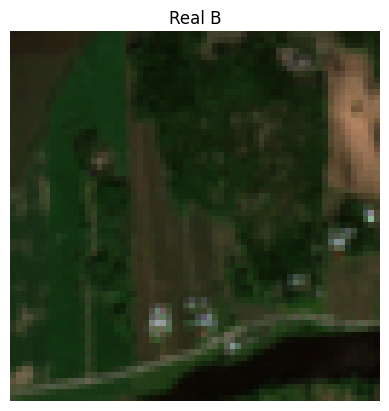

In [ ]:
img_path = example_image[:-10] + "real_B.npy"
img = np.load(os.path.expanduser(img_path))
image = img[:, :, [2, 1, 0]]
# image = img[:, :, [3]]

plt.imshow(image)
plt.title("Real B")
plt.axis('off')
plt.show()

## TRAIN

Finally, we arrive at a step where we prepared all our data and can start to train our classifier.

### Setup

We import the necessary libraries and set seeds for the best possible reproducibility (it is still not deterministic).

In [ ]:
!pip install -q torchsummary
!pip install -q hiddenlayer

In [2]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import numpy as np
import torch
import pandas as pd

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


### Get training data

To skip the long Pix2Pix training time, we can start executing the notebook here and select the appropriate model from our Google Drive.

In [3]:
model_if_not_trained = 7

We prepare our training data such that we have the proper full paths to their (runtime local) storage and split it into train (~70%), val (~15%) and test (15%).

In [4]:
from sklearn.model_selection import train_test_split

# Handle the different paths our data can have depending on generation or loading from Google Drive
if os.path.exists(os.path.expanduser("~/train_rft/pix2pix_MajTOM/test_latest/images/")):
  img_path = os.path.expanduser("~/train_rft/pix2pix_MajTOM/test_latest/images/")
elif os.path.exists(os.path.expanduser("~/train_rft/root/train_rft/pix2pix_MajTOM/test_latest/images/")):
  img_path = os.path.expanduser("~/train_rft/root/train_rft/pix2pix_MajTOM/test_latest/images/")
else:
  !cp models/Pix2Pix_Model_{model_if_not_trained}/train_rft.zip ~/train_rft.zip
  !unzip -q ~/train_rft.zip -d ~/train_rft
  !rm -rf ~/train_rft.zip
  img_path = os.path.expanduser("~/train_rft/root/train_rft/pix2pix_MajTOM/test_latest/images/")

# We only want the "fake_B", i.e., the generated images
df = pd.DataFrame(os.listdir(img_path))
df = df[df[0].str.contains("fake_B")]

# We prepare the data to split it into the different sets
df["label"] = df[0].apply(lambda x: x.split("_")[0])
df["full_path"] = df[0].apply(lambda x: os.path.join(img_path, x))
X = df["full_path"]
y = df["label"]

# Split the data into train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=seed_value)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, stratify=y_train, random_state=seed_value)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom DataLoader
class EuroSATDataset(Dataset):
    def __init__(self, data_paths, labels, transform=None, mode="train"):
        self.data_paths = data_paths
        # Handle labels (training, val, testing) and ids (real testing on our challenge data)
        self.labels = labels.apply(lambda x: class_to_idx[x]) if mode == "train" else labels
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        img_path = self.data_paths[idx]

        # Data should be in uint8 to be in control of all conversions when transforming to tensor
        image = np.interp(np.load(img_path), (0, 2750), (0, 255)).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        # Handle labels (training, val, testing) and ids (real testing on our challenge data)
        if self.mode == "train":
            label = self.labels[idx]
            return image, label
        else:
            id = int(img_path.split("/")[-1].split("_")[1])
            return image, id

# Define transformations to augment data
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])
transform_val = transforms.Compose([
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.ToTensor()
])

# Define all classes and their reverse lookup
all_class_names = ['HerbaceousVegetation', 'Highway', 'Forest', 'SeaLake', 'PermanentCrop', 'River', 'Pasture', 'Industrial', 'AnnualCrop', 'Residential']
class_to_idx = {class_name: idx for idx, class_name in enumerate(all_class_names)}

# Create datasets and dataloaders
train_dataset = EuroSATDataset(X_train, y_train, transform=transform_train, mode="train")
test_dataset = EuroSATDataset(X_val, y_val, transform=transform_val, mode="train")
score_dataset = EuroSATDataset(X_test, y_test, transform=transform_val, mode="train")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
score_loader = test_loader = DataLoader(score_dataset, batch_size=32, shuffle=False, num_workers=4)

### Train model

We define the name that our model should be stored under to differentiate between different models.

In [44]:
resnet_name_suffix = "7"

We use a pretrained ResNet50 to classify our images. We adapt the first and the last layer for our task of 4 channel images that should be classified into 10 categories.

In [45]:
from torchvision import models
from torchvision.models import ResNet50_Weights
import cv2

# We use a pretrained resnet50
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# We define that we want to feed 4 channels into the model.
# Using a small kernel, stride & padding worked best in our experiments
model.conv1 = torch.nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=False)
# To prevent overfitting to some extent, we use a dropout before the final
# layer. The final layer defines our 10 classes that we want to distinguish.
original_fc = model.fc
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(original_fc.in_features, 10)
)
# Send the model to device (CUDA)
model.to(device)
# Define criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Let's take a look at our model.

In [ ]:
from torchsummary import summary

summary(model, input_size=(4, 64, 64))

In [ ]:
import hiddenlayer as hl

hl_graph = hl.build_graph(model, torch.zeros([1, 4, 64, 64]).to(device))
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph

Training...

In [46]:
# Checkpointing and Early Stopping setup
num_epochs = 10
best_test_loss = float('inf')
patience_counter = 0
patience = 5  # How many epochs to wait after last time validation loss improved
file_path = f"./models/resnet50_{resnet_name_suffix}.pt"

# We iterate through the epochs
for epoch in range(num_epochs):
    # First we train
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        optimizer.zero_grad() # same as model.zero_grad if all params in optimizer
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)

    # Then we validate
    model.eval()
    test_losses = []
    total_correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()
    test_loss = np.mean(test_losses)
    test_accuracy = total_correct / len(test_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}")

    # Checkpointing when validation loss increased
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), file_path)
        patience_counter = 0  # Reset counter if test loss improves
        print(f"Val loss improved to {test_loss:.4f}. Model saved.")
    else:
        patience_counter += 1
        print(f"Val loss did not improve. Patience counter: {patience_counter}")

    # Early stopping when patience is triggered
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/10, Train Loss: 0.4696, Test Loss: 0.2130, Test Accuracy: 0.9246
Test loss improved to 0.2130. Model saved.
Epoch 2/10, Train Loss: 0.2119, Test Loss: 0.1336, Test Accuracy: 0.9572
Test loss improved to 0.1336. Model saved.
Epoch 3/10, Train Loss: 0.1676, Test Loss: 0.1104, Test Accuracy: 0.9663
Test loss improved to 0.1104. Model saved.
Epoch 4/10, Train Loss: 0.1389, Test Loss: 0.0917, Test Accuracy: 0.9689
Test loss improved to 0.0917. Model saved.
Epoch 5/10, Train Loss: 0.1253, Test Loss: 0.0925, Test Accuracy: 0.9713
Test loss did not improve. Patience counter: 1
Epoch 6/10, Train Loss: 0.1064, Test Loss: 0.0817, Test Accuracy: 0.9743
Test loss improved to 0.0817. Model saved.
Epoch 7/10, Train Loss: 0.0936, Test Loss: 0.0816, Test Accuracy: 0.9744
Test loss improved to 0.0816. Model saved.
Epoch 8/10, Train Loss: 0.0844, Test Loss: 0.1018, Test Accuracy: 0.9663
Test loss did not improve. Patience counter: 1
Epoch 9/10, Train Loss: 0.0790, Test Loss: 0.0723, Test Accuracy

Validate:

In [ ]:
predictions = []
image_ids = []
# Load the best saved model's weights
model.load_state_dict(torch.load(file_path))
model.eval()

with torch.no_grad():
    for inputs, ids in score_loader:
        inputs, ids = inputs.to(device), ids.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_classes = [all_class_names[idx] for idx in predicted.cpu().numpy()]
        predictions.extend(predicted_classes)
        image_ids.extend(ids.cpu().tolist())

prediction_results = list(zip(image_ids, predictions))
df = pd.DataFrame(prediction_results, columns=["test_id", "label"])
df_sorted = df.sort_values(by="test_id")
df_sorted

## TEST

In [47]:
if os.path.exists(os.path.expanduser("~/test_rft/pix2pix_MajTOM/test_latest/images/")):
  img_path = os.path.expanduser("~/test_rft/pix2pix_MajTOM/test_latest/images/")
elif os.path.exists(os.path.expanduser("~/test_rft/root/test_rft/pix2pix_MajTOM/test_latest/images/")):
  img_path = os.path.expanduser("~/test_rft/root/test_rft/pix2pix_MajTOM/test_latest/images/")
else:
  !cp models/Pix2Pix_Model_{model_if_not_trained}/test_rft.zip ~/test_rft.zip
  !unzip -q ~/test_rft.zip -d ~/test_rft
  !rm -rf ~/test_rft.zip
  img_path = os.path.expanduser("~/test_rft/root/test_rft/pix2pix_MajTOM/test_latest/images/")

df = pd.DataFrame(os.listdir(img_path))
df = df[df[0].str.contains("real_B")]

df["full_path"] = df[0].apply(lambda x: os.path.join(img_path, x))

pred_paths = df.sort_values(by="full_path")
sorted_pred_paths = pred_paths.reset_index(drop=True)
prediction_paths = sorted_pred_paths["full_path"]

prediction_dataset = EuroSATDataset(prediction_paths, None, transform=transform_test, mode="predict")
prediction_loader = DataLoader(prediction_dataset, batch_size=32, shuffle=False, num_workers=4)

In [48]:
predictions = []
image_ids = []
# Load the best saved model's weights
model.load_state_dict(torch.load(file_path))
model.eval()
with torch.no_grad():
    for inputs, ids in prediction_loader:
        inputs, ids = inputs.to(device), ids.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_classes = [all_class_names[idx] for idx in predicted.cpu().numpy()]
        predictions.extend(predicted_classes)
        image_ids.extend(ids.cpu().tolist())

prediction_results = list(zip(image_ids, predictions))
df = pd.DataFrame(prediction_results, columns=["test_id", "label"])
df_sorted = df.sort_values(by="test_id")
df_sorted.to_csv(f"model_{resnet_name_suffix}.csv", index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
